In [1]:
from neural_bandits.trainers.linear_bandit_module import LinearBanditModule
from neural_bandits.algorithms.linear_bandits import LinearTSBandit, LinearUCBBandit
from neural_bandits.datasets.statlog import StatlogDataset

import torch
import lightning as pl
from torch.utils.data import DataLoader

In [2]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = LinearBanditModule(
        linear_bandit_type = LinearUCBBandit,
        n_features = dataset.context_size * dataset.num_actions,
)
logger = pl.pytorch.loggers.CSVLogger("logs", name="linear_bandit", flush_logs_every_n_steps=100)
trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1)

/hpi/fs00/home/robert.weeke/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpi/fs00/home/robert.weeke/miniconda3/envs/neural_b ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


7
58000


In [3]:
trainer.fit(model, train_loader)

/hpi/fs00/home/robert.weeke/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name   | Type            | Params | Mode 
---------------------------------------------------
0 | bandit | LinearUCBBandit | 0      | train
---------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
/hpi/fs00/home/robert.weeke/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 58000/58000 [03:47<00:00, 255.07it/s, v_num=2, reward=0.000, regret=1.000]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 58000/58000 [03:47<00:00, 255.07it/s, v_num=2, reward=0.000, regret=1.000]


In [7]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:1000])
cumulative_regret = np.cumsum(metrics["regret"][:1000])

logs/linear_bandit/version_2/metrics.csv


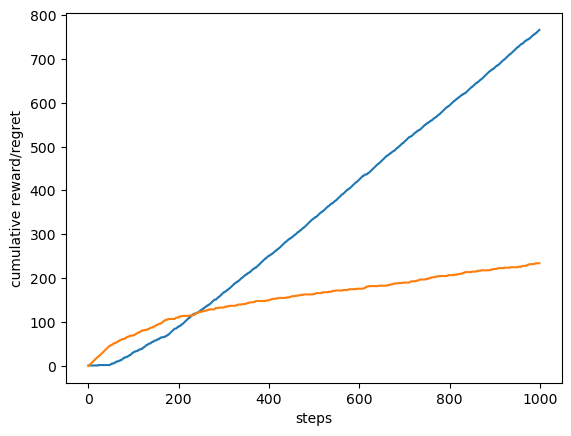

In [8]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward)
plt.plot(cumulative_regret)
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.show()

In [9]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:100]) / 100)
print(sum(metrics["regret"][:1000]) / 1000)
print(sum(metrics["regret"][:10000]) / 10000)


0.3
0.766
0.8759
0.7
0.234
0.1241
